In [15]:
%load_ext autoreload
%autoreload 2

import os
import time

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets.vision import VisionDataset
from torch.utils.data import DataLoader
from torchvision import transforms


from datasets import BadNetsDataset, WaNetDataset, SIGDataset
from simclr import SimClrBackbone

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
device = "cuda"
epochs = 300
batch_size = 128

In [17]:
LOAD_CHECKPOINT = False
CHECKPOINT_NAME = "SIG-SimCLR-300.pt"

DATASET = "sig"

if DATASET == "badnets":
    TARGET_CLASS = 1
elif DATASET == "wanet":
    TARGET_CLASS = 0
elif DATASET == "sig":
    TARGET_CLASS = 0
else:
    raise Exception("Invalid dataset")

## Poison dataset

In [18]:
dataset = torchvision.datasets.CIFAR10(root='C:/Datasets', train=True, download=True)

if DATASET == "badnets":
    poison_dataset = BadNetsDataset(dataset, TARGET_CLASS, "triggers/trigger_10.png", seed=1)
elif DATASET == "wanet":
    poison_dataset = WaNetDataset(dataset, TARGET_CLASS, seed=1)
elif DATASET == "sig":
    poison_dataset = SIGDataset(dataset, TARGET_CLASS, 20, 6, seed=1)
else:
    raise Exception("Invalid dataset")

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## SimCLR data augmentations

In [19]:
class ConstrastiveDataset(VisionDataset):

    def __init__(self, original_dataset: VisionDataset, s: int = 0.5):
        self.original_dataset = original_dataset

        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomResizedCrop(32,(0.8,1.0),antialias=False),
            transforms.Compose([transforms.RandomApply([
                transforms.ColorJitter(0.8*s, 0.8*s, 0.8*s, 0.2*s)], p = 0.8),
                transforms.RandomGrayscale(p=0.2)]),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
            ])
    
    def __len__(self):
        return len(self.original_dataset)
    
    def __getitem__(self, index):
        img = self.original_dataset[index][0]
        augmented_img_1 = self.transforms(img)
        augmented_img_2 = self.transforms(img)
        return augmented_img_1, augmented_img_2
    
constrastive_dataset = ConstrastiveDataset(poison_dataset)

## SimCLR model

In [20]:
model = SimClrBackbone()
model = model.to(device)

c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## LARS optimizer

In [21]:
from torch.optim.optimizer import Optimizer, required
import re

EETA_DEFAULT = 0.001


class LARS(Optimizer):
    """
    Layer-wise Adaptive Rate Scaling for large batch training.
    Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
    I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)
    """

    def __init__(
        self,
        params,
        lr=required,
        momentum=0.9,
        use_nesterov=False,
        weight_decay=0.0,
        exclude_from_weight_decay=None,
        exclude_from_layer_adaptation=None,
        classic_momentum=True,
        eeta=EETA_DEFAULT,
    ):
        """Constructs a LARSOptimizer.
        Args:
        lr: A `float` for learning rate.
        momentum: A `float` for momentum.
        use_nesterov: A 'Boolean' for whether to use nesterov momentum.
        weight_decay: A `float` for weight decay.
        exclude_from_weight_decay: A list of `string` for variable screening, if
            any of the string appears in a variable's name, the variable will be
            excluded for computing weight decay. For example, one could specify
            the list like ['batch_normalization', 'bias'] to exclude BN and bias
            from weight decay.
        exclude_from_layer_adaptation: Similar to exclude_from_weight_decay, but
            for layer adaptation. If it is None, it will be defaulted the same as
            exclude_from_weight_decay.
        classic_momentum: A `boolean` for whether to use classic (or popular)
            momentum. The learning rate is applied during momeuntum update in
            classic momentum, but after momentum for popular momentum.
        eeta: A `float` for scaling of learning rate when computing trust ratio.
        name: The name for the scope.
        """

        self.epoch = 0
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_nesterov=use_nesterov,
            weight_decay=weight_decay,
            exclude_from_weight_decay=exclude_from_weight_decay,
            exclude_from_layer_adaptation=exclude_from_layer_adaptation,
            classic_momentum=classic_momentum,
            eeta=eeta,
        )

        super(LARS, self).__init__(params, defaults)
        self.lr = lr
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.use_nesterov = use_nesterov
        self.classic_momentum = classic_momentum
        self.eeta = eeta
        self.exclude_from_weight_decay = exclude_from_weight_decay
        # exclude_from_layer_adaptation is set to exclude_from_weight_decay if the
        # arg is None.
        if exclude_from_layer_adaptation:
            self.exclude_from_layer_adaptation = exclude_from_layer_adaptation
        else:
            self.exclude_from_layer_adaptation = exclude_from_weight_decay

    def step(self, epoch=None, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        if epoch is None:
            epoch = self.epoch
            self.epoch += 1

        for group in self.param_groups:
            weight_decay = group["weight_decay"]
            momentum = group["momentum"]
            eeta = group["eeta"]
            lr = group["lr"]

            for p in group["params"]:
                if p.grad is None:
                    continue

                param = p.data
                grad = p.grad.data

                param_state = self.state[p]

                # TODO: get param names
                # if self._use_weight_decay(param_name):
                grad += self.weight_decay * param

                if self.classic_momentum:
                    trust_ratio = 1.0

                    # TODO: get param names
                    # if self._do_layer_adaptation(param_name):
                    w_norm = torch.norm(param)
                    g_norm = torch.norm(grad)

                    device = g_norm.get_device()
                    trust_ratio = torch.where(
                        w_norm.gt(0),
                        torch.where(
                            g_norm.gt(0),
                            (self.eeta * w_norm / g_norm),
                            torch.Tensor([1.0]).to(device),
                        ),
                        torch.Tensor([1.0]).to(device),
                    ).item()

                    scaled_lr = lr * trust_ratio
                    if "momentum_buffer" not in param_state:
                        next_v = param_state["momentum_buffer"] = torch.zeros_like(
                            p.data
                        )
                    else:
                        next_v = param_state["momentum_buffer"]

                    next_v.mul_(momentum).add_(scaled_lr, grad)
                    if self.use_nesterov:
                        update = (self.momentum * next_v) + (scaled_lr * grad)
                    else:
                        update = next_v

                    p.data.add_(-update)
                else:
                    raise NotImplementedError

        return loss

    def _use_weight_decay(self, param_name):
        """Whether to use L2 weight decay for `param_name`."""
        if not self.weight_decay:
            return False
        if self.exclude_from_weight_decay:
            for r in self.exclude_from_weight_decay:
                if re.search(r, param_name) is not None:
                    return False
        return True

    def _do_layer_adaptation(self, param_name):
        """Whether to do layer-wise learning rate adaptation for `param_name`."""
        if self.exclude_from_layer_adaptation:
            for r in self.exclude_from_layer_adaptation:
                if re.search(r, param_name) is not None:
                    return False
        return True

## SimCLR contrastive loss

In [22]:
class SimCLR_Loss(nn.Module):
    def __init__(self, temperature):
        super(SimCLR_Loss, self).__init__()
        self.temperature = temperature

        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
            
        return mask

    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        batch_size = z_i.shape[0]
        mask = self.mask_correlated_samples(batch_size)

        N = 2 * batch_size #* self.world_size
        
        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        
        #print(sim.shape)

        sim_i_j = torch.diag(sim, batch_size)
        sim_j_i = torch.diag(sim, batch_size)
        
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[mask].reshape(N, -1)
        
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

## Training

In [23]:
optimizer = LARS(
    [params for params in model.parameters() if params.requires_grad],
    lr=0.2,
    weight_decay=1e-6,
    exclude_from_weight_decay=["batch_normalization", "bias"],
)

# "decay the learning rate with the cosine decay schedule without restarts"
warmupscheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch : (epoch+1)/10.0, verbose = False)
mainscheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 500, eta_min=0.05, last_epoch=-1, verbose = False)

criterion = SimCLR_Loss(temperature=0.5)

dataloader = DataLoader(constrastive_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_no_contrastive = DataLoader(poison_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

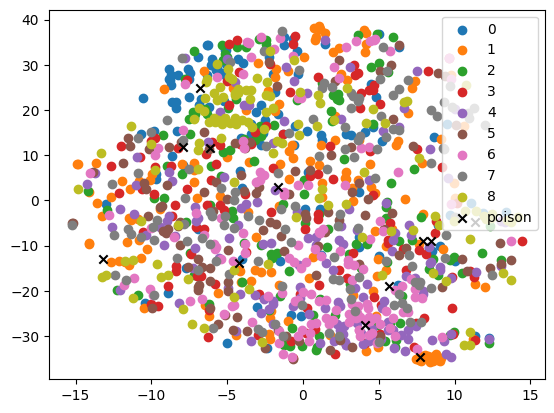

In [24]:
from sklearn.manifold import TSNE

def plot_features(model: nn.Module, dataloader: DataLoader, batches: int = None):
    model.eval()

    features = None
    labels_poison = None
    labels_true = None

    for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

        if batches is not None and i>=batches:
            break
    
        with torch.no_grad():
            features_batch = model(img.to(device)).cpu().data.numpy()
            
        if features is None:
            features = features_batch
            labels_poison = labels_batch_poison
            labels_true = labels_batch_true
        else:
            features = np.append(features, features_batch, axis=0)
            labels_poison = np.append(labels_poison, labels_batch_poison, axis=0)
            labels_true = np.append(labels_true, labels_batch_true, axis=0)
    
    tsne = TSNE(n_components = 2, perplexity = 50)
    tsne_features = tsne.fit_transform(features)
    num_classes = max(labels_batch_poison)

    labels = labels_true[:]
    labels[[poison_dataset.is_poison(i) for i in range(len(labels))]] = 10

    for i in range(num_classes):
        plt.scatter(tsne_features[labels==i,1], tsne_features[labels==i,0])
    plt.scatter(tsne_features[labels==10,1], tsne_features[labels==10,0], c = "black", marker= "x")

    plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()

    model.train()

plot_features(model, dataloader_no_contrastive, 10)

In [25]:
def train(dataloader, model, criterion, optimizer):
    loss_epoch = 0
    
    for step, (x_i, x_j) in enumerate(dataloader):
        optimizer.zero_grad()
        x_i = x_i.to(device).float()
        x_j = x_j.to(device).float()

        # positive pair, with encoding
        z_i = model(x_i)
        z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()
        
        if step % 50 == 0:
            print(f"\tStep [{step}/{len(dataloader)}]\t Loss: {round(loss.item(), 5)}")

        loss_epoch += loss.item()
    return loss_epoch / len(dataloader)

In [26]:
def save_model(model, optimizer, scheduler, epoch, name):
    out = os.path.join('./saved_models/', name)

    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'epoch': epoch
                }, out)

    print(f"\tSaved model, optimizer, scheduler and epoch info to {out}")

In [27]:
start_epoch = 0

load_checkpoint = False

if LOAD_CHECKPOINT:
    out = os.path.join('./saved_models/', CHECKPOINT_NAME)
    checkpoint = torch.load(out, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    mainscheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    start_epoch = checkpoint["epoch"] + 1

Epoch [0/300]	
	Step [0/391]	 Loss: 5.20288
	Step [50/391]	 Loss: 4.43687
	Step [100/391]	 Loss: 4.06985
	Step [150/391]	 Loss: 3.95512
	Step [200/391]	 Loss: 3.84256
	Step [250/391]	 Loss: 3.82214
	Step [300/391]	 Loss: 3.81501
	Step [350/391]	 Loss: 3.7906

	Training Loss: 4.026599904765254
	Time Taken: 3.8121350606282554 minutes
	Saved model, optimizer, scheduler and epoch info to ./saved_models/NEW-SimCLR-0.pt


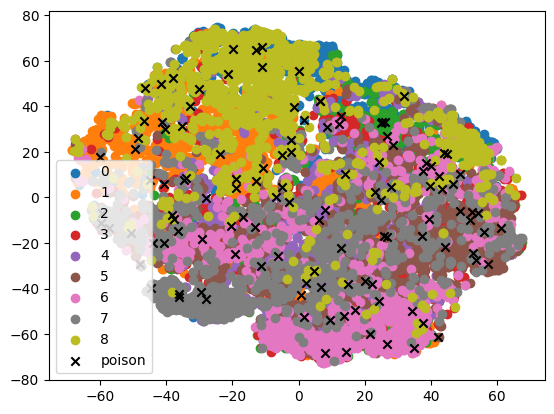

Epoch [1/300]	
	Step [0/391]	 Loss: 3.76149
	Step [50/391]	 Loss: 3.77138
	Step [100/391]	 Loss: 3.76317
	Step [150/391]	 Loss: 3.76214
	Step [200/391]	 Loss: 3.74996
	Step [250/391]	 Loss: 3.74435
	Step [300/391]	 Loss: 3.75187
	Step [350/391]	 Loss: 3.76194

	Training Loss: 3.7580344707459745
	Time Taken: 3.8204110423723856 minutes
Epoch [2/300]	
	Step [0/391]	 Loss: 3.74742
	Step [50/391]	 Loss: 3.74294
	Step [100/391]	 Loss: 3.7451
	Step [150/391]	 Loss: 3.75998
	Step [200/391]	 Loss: 3.74821
	Step [250/391]	 Loss: 3.75152
	Step [300/391]	 Loss: 3.76046
	Step [350/391]	 Loss: 3.7397

	Training Loss: 3.739866721965468
	Time Taken: 3.8308603008588156 minutes
Epoch [3/300]	
	Step [0/391]	 Loss: 3.73563
	Step [50/391]	 Loss: 3.75227
	Step [100/391]	 Loss: 3.74677
	Step [150/391]	 Loss: 3.72706
	Step [200/391]	 Loss: 3.71756
	Step [250/391]	 Loss: 3.72024
	Step [300/391]	 Loss: 3.74029
	Step [350/391]	 Loss: 3.7043

	Training Loss: 3.725400979561574
	Time Taken: 3.8074462175369264 minut

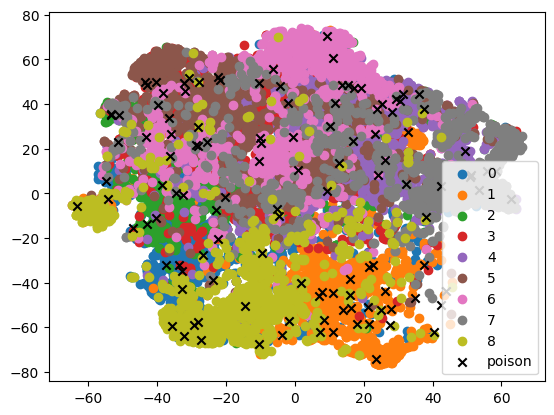

Epoch [11/300]	
	Step [0/391]	 Loss: 3.66924
	Step [50/391]	 Loss: 3.664
	Step [100/391]	 Loss: 3.66684
	Step [150/391]	 Loss: 3.66807
	Step [200/391]	 Loss: 3.68792
	Step [250/391]	 Loss: 3.66825
	Step [300/391]	 Loss: 3.65941
	Step [350/391]	 Loss: 3.65529

	Training Loss: 3.6644474758821377
	Time Taken: 3.805103282133738 minutes
Epoch [12/300]	
	Step [0/391]	 Loss: 3.67185
	Step [50/391]	 Loss: 3.68511
	Step [100/391]	 Loss: 3.6558
	Step [150/391]	 Loss: 3.6714
	Step [200/391]	 Loss: 3.66351
	Step [250/391]	 Loss: 3.66252
	Step [300/391]	 Loss: 3.65432
	Step [350/391]	 Loss: 3.6592

	Training Loss: 3.659723665403283
	Time Taken: 3.7985538641611734 minutes
Epoch [13/300]	
	Step [0/391]	 Loss: 3.68092
	Step [50/391]	 Loss: 3.66522
	Step [100/391]	 Loss: 3.65622
	Step [150/391]	 Loss: 3.6444
	Step [200/391]	 Loss: 3.64165
	Step [250/391]	 Loss: 3.6452
	Step [300/391]	 Loss: 3.65955
	Step [350/391]	 Loss: 3.65226

	Training Loss: 3.6560609212616826
	Time Taken: 3.7945013801256815 minute

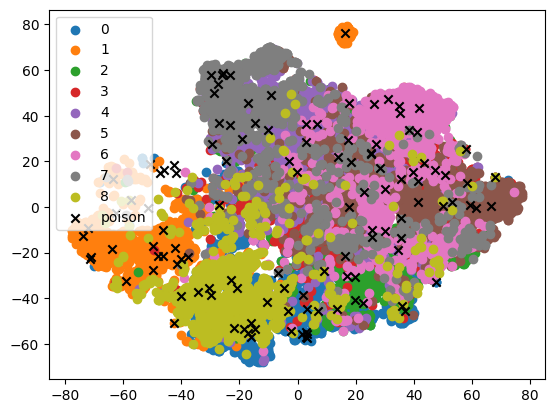

Epoch [21/300]	
	Step [0/391]	 Loss: 3.63195
	Step [50/391]	 Loss: 3.6509
	Step [100/391]	 Loss: 3.64641
	Step [150/391]	 Loss: 3.63727
	Step [200/391]	 Loss: 3.63238
	Step [250/391]	 Loss: 3.6436
	Step [300/391]	 Loss: 3.64579
	Step [350/391]	 Loss: 3.63699

	Training Loss: 3.640224406786282
	Time Taken: 3.797875245412191 minutes
Epoch [22/300]	
	Step [0/391]	 Loss: 3.6336
	Step [50/391]	 Loss: 3.63072
	Step [100/391]	 Loss: 3.64014
	Step [150/391]	 Loss: 3.63335
	Step [200/391]	 Loss: 3.63934
	Step [250/391]	 Loss: 3.63753
	Step [300/391]	 Loss: 3.63617
	Step [350/391]	 Loss: 3.64186

	Training Loss: 3.6388857413435836
	Time Taken: 3.7917203068733216 minutes
Epoch [23/300]	
	Step [0/391]	 Loss: 3.63945
	Step [50/391]	 Loss: 3.64969
	Step [100/391]	 Loss: 3.64271
	Step [150/391]	 Loss: 3.63117
	Step [200/391]	 Loss: 3.63321
	Step [250/391]	 Loss: 3.63458
	Step [300/391]	 Loss: 3.63306
	Step [350/391]	 Loss: 3.64908

	Training Loss: 3.6377147262358602
	Time Taken: 3.810875101884206 min

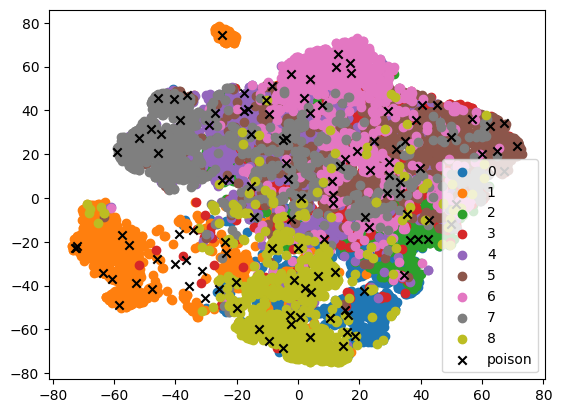

Epoch [31/300]	
	Step [0/391]	 Loss: 3.62504
	Step [50/391]	 Loss: 3.63079
	Step [100/391]	 Loss: 3.63199
	Step [150/391]	 Loss: 3.63399
	Step [200/391]	 Loss: 3.62758
	Step [250/391]	 Loss: 3.63178
	Step [300/391]	 Loss: 3.62933
	Step [350/391]	 Loss: 3.63042

	Training Loss: 3.62945781644348
	Time Taken: 3.7947782039642335 minutes
Epoch [32/300]	
	Step [0/391]	 Loss: 3.62945
	Step [50/391]	 Loss: 3.61956
	Step [100/391]	 Loss: 3.63798
	Step [150/391]	 Loss: 3.63384
	Step [200/391]	 Loss: 3.62242
	Step [250/391]	 Loss: 3.63884
	Step [300/391]	 Loss: 3.64013
	Step [350/391]	 Loss: 3.64124

	Training Loss: 3.628901696875882
	Time Taken: 3.8084041555722554 minutes
Epoch [33/300]	
	Step [0/391]	 Loss: 3.62485
	Step [50/391]	 Loss: 3.63536
	Step [100/391]	 Loss: 3.63767
	Step [150/391]	 Loss: 3.63584
	Step [200/391]	 Loss: 3.62427
	Step [250/391]	 Loss: 3.64204
	Step [300/391]	 Loss: 3.63217
	Step [350/391]	 Loss: 3.63951

	Training Loss: 3.628644363349661
	Time Taken: 3.799628742535909 mi

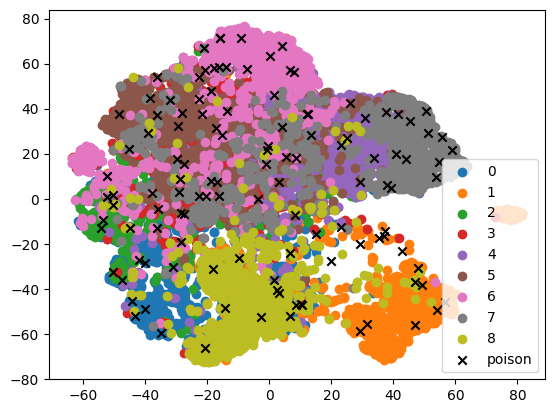

Epoch [41/300]	
	Step [0/391]	 Loss: 3.63087
	Step [50/391]	 Loss: 3.62462
	Step [100/391]	 Loss: 3.6212
	Step [150/391]	 Loss: 3.61998
	Step [200/391]	 Loss: 3.62422
	Step [250/391]	 Loss: 3.62064
	Step [300/391]	 Loss: 3.62105
	Step [350/391]	 Loss: 3.62535

	Training Loss: 3.62275702081373
	Time Taken: 3.800022292137146 minutes
Epoch [42/300]	
	Step [0/391]	 Loss: 3.62493
	Step [50/391]	 Loss: 3.62522
	Step [100/391]	 Loss: 3.62687
	Step [150/391]	 Loss: 3.62061
	Step [200/391]	 Loss: 3.62227
	Step [250/391]	 Loss: 3.61797
	Step [300/391]	 Loss: 3.62401
	Step [350/391]	 Loss: 3.62709

	Training Loss: 3.6224084101674503
	Time Taken: 3.7905556837717693 minutes
Epoch [43/300]	
	Step [0/391]	 Loss: 3.61751
	Step [50/391]	 Loss: 3.62236
	Step [100/391]	 Loss: 3.61775
	Step [150/391]	 Loss: 3.62524
	Step [200/391]	 Loss: 3.62743
	Step [250/391]	 Loss: 3.62302
	Step [300/391]	 Loss: 3.62128
	Step [350/391]	 Loss: 3.62008

	Training Loss: 3.621818462601098
	Time Taken: 3.7977056662241617 mi

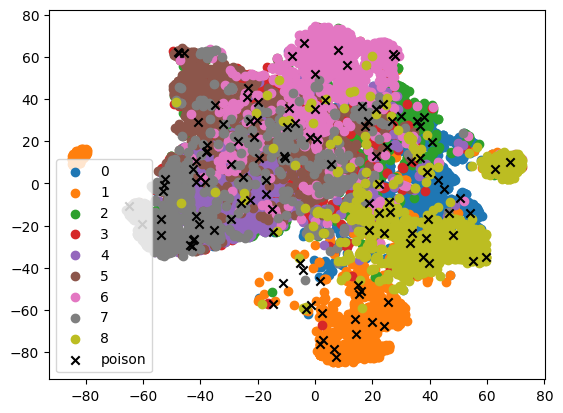

Epoch [51/300]	
	Step [0/391]	 Loss: 3.6136
	Step [50/391]	 Loss: 3.62166
	Step [100/391]	 Loss: 3.62188
	Step [150/391]	 Loss: 3.61805
	Step [200/391]	 Loss: 3.61686
	Step [250/391]	 Loss: 3.63233
	Step [300/391]	 Loss: 3.62151
	Step [350/391]	 Loss: 3.62217

	Training Loss: 3.61815187205439
	Time Taken: 3.8001609563827516 minutes
Epoch [52/300]	
	Step [0/391]	 Loss: 3.61347
	Step [50/391]	 Loss: 3.62079
	Step [100/391]	 Loss: 3.62249
	Step [150/391]	 Loss: 3.62409
	Step [200/391]	 Loss: 3.61752
	Step [250/391]	 Loss: 3.62496
	Step [300/391]	 Loss: 3.61742
	Step [350/391]	 Loss: 3.61976

	Training Loss: 3.6179962865531903
	Time Taken: 3.794844309488932 minutes
Epoch [53/300]	
	Step [0/391]	 Loss: 3.62039
	Step [50/391]	 Loss: 3.61896
	Step [100/391]	 Loss: 3.62364
	Step [150/391]	 Loss: 3.61435
	Step [200/391]	 Loss: 3.62336
	Step [250/391]	 Loss: 3.61634
	Step [300/391]	 Loss: 3.61796
	Step [350/391]	 Loss: 3.62379

	Training Loss: 3.61759310305271
	Time Taken: 3.7935460766156512 min

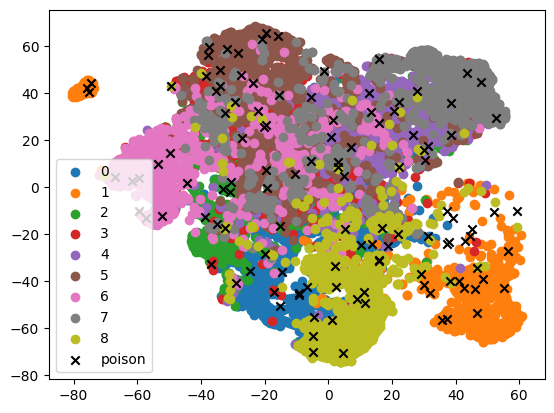

Epoch [61/300]	
	Step [0/391]	 Loss: 3.61265
	Step [50/391]	 Loss: 3.61666
	Step [100/391]	 Loss: 3.61689
	Step [150/391]	 Loss: 3.61621
	Step [200/391]	 Loss: 3.6169
	Step [250/391]	 Loss: 3.60832
	Step [300/391]	 Loss: 3.61587
	Step [350/391]	 Loss: 3.62141

	Training Loss: 3.6143284776936406
	Time Taken: 3.7956640839576723 minutes
Epoch [62/300]	
	Step [0/391]	 Loss: 3.61985
	Step [50/391]	 Loss: 3.61798
	Step [100/391]	 Loss: 3.61963
	Step [150/391]	 Loss: 3.61802
	Step [200/391]	 Loss: 3.61198
	Step [250/391]	 Loss: 3.61666
	Step [300/391]	 Loss: 3.61302
	Step [350/391]	 Loss: 3.619

	Training Loss: 3.614372280247681
	Time Taken: 3.799997691313426 minutes
Epoch [63/300]	
	Step [0/391]	 Loss: 3.6239
	Step [50/391]	 Loss: 3.62292
	Step [100/391]	 Loss: 3.61657
	Step [150/391]	 Loss: 3.6164
	Step [200/391]	 Loss: 3.61694
	Step [250/391]	 Loss: 3.60849
	Step [300/391]	 Loss: 3.61657
	Step [350/391]	 Loss: 3.62195

	Training Loss: 3.6136594489407354
	Time Taken: 3.7879977941513063 minu

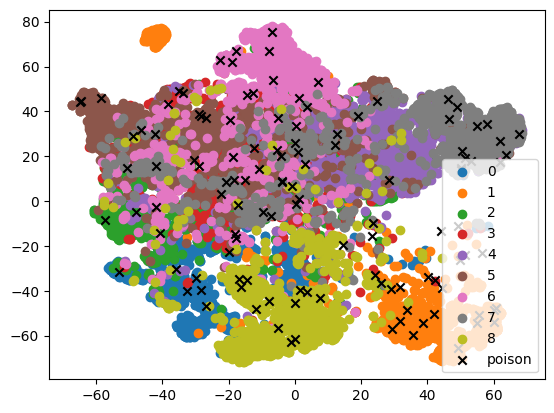

Epoch [71/300]	
	Step [0/391]	 Loss: 3.61782
	Step [50/391]	 Loss: 3.61105
	Step [100/391]	 Loss: 3.60766
	Step [150/391]	 Loss: 3.61219
	Step [200/391]	 Loss: 3.61165
	Step [250/391]	 Loss: 3.61081
	Step [300/391]	 Loss: 3.61604
	Step [350/391]	 Loss: 3.61546

	Training Loss: 3.6112442644660736
	Time Taken: 3.7863488594690957 minutes
Epoch [72/300]	
	Step [0/391]	 Loss: 3.60764
	Step [50/391]	 Loss: 3.6106
	Step [100/391]	 Loss: 3.61065
	Step [150/391]	 Loss: 3.6071
	Step [200/391]	 Loss: 3.61695
	Step [250/391]	 Loss: 3.61291
	Step [300/391]	 Loss: 3.61226
	Step [350/391]	 Loss: 3.60843

	Training Loss: 3.6108380790866548
	Time Taken: 3.7929155508677166 minutes
Epoch [73/300]	
	Step [0/391]	 Loss: 3.61581
	Step [50/391]	 Loss: 3.6142
	Step [100/391]	 Loss: 3.61299
	Step [150/391]	 Loss: 3.60806
	Step [200/391]	 Loss: 3.61014
	Step [250/391]	 Loss: 3.61256
	Step [300/391]	 Loss: 3.61469
	Step [350/391]	 Loss: 3.61298

	Training Loss: 3.610746911114744
	Time Taken: 3.7985157052675884 m

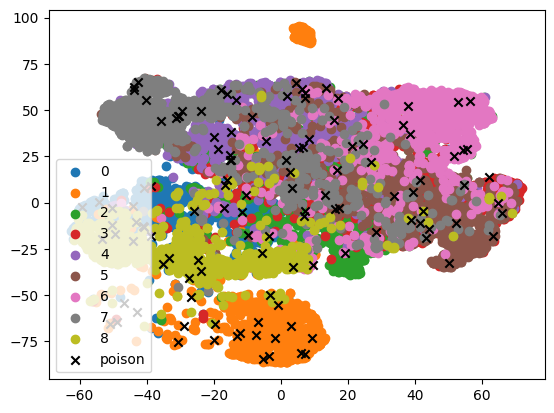

Epoch [81/300]	
	Step [0/391]	 Loss: 3.61103
	Step [50/391]	 Loss: 3.6055
	Step [100/391]	 Loss: 3.60747
	Step [150/391]	 Loss: 3.60793
	Step [200/391]	 Loss: 3.60653
	Step [250/391]	 Loss: 3.60966
	Step [300/391]	 Loss: 3.61205
	Step [350/391]	 Loss: 3.60984

	Training Loss: 3.6086135587423964
	Time Taken: 3.796749111016591 minutes
Epoch [82/300]	
	Step [0/391]	 Loss: 3.60793
	Step [50/391]	 Loss: 3.60611
	Step [100/391]	 Loss: 3.60545
	Step [150/391]	 Loss: 3.61015
	Step [200/391]	 Loss: 3.59966
	Step [250/391]	 Loss: 3.60935
	Step [300/391]	 Loss: 3.60187
	Step [350/391]	 Loss: 3.61205

	Training Loss: 3.6086990333274196
	Time Taken: 3.7868996461232505 minutes
Epoch [83/300]	
	Step [0/391]	 Loss: 3.60944
	Step [50/391]	 Loss: 3.60466
	Step [100/391]	 Loss: 3.60446
	Step [150/391]	 Loss: 3.61206
	Step [200/391]	 Loss: 3.60629
	Step [250/391]	 Loss: 3.60733
	Step [300/391]	 Loss: 3.6167
	Step [350/391]	 Loss: 3.611

	Training Loss: 3.6083182227581054
	Time Taken: 3.78986626068751 minu

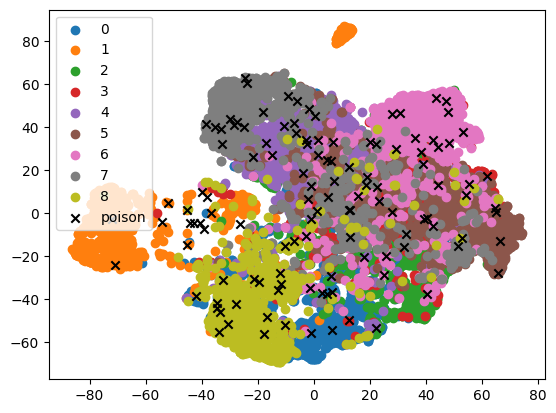

Epoch [91/300]	
	Step [0/391]	 Loss: 3.60735
	Step [50/391]	 Loss: 3.60517
	Step [100/391]	 Loss: 3.61004
	Step [150/391]	 Loss: 3.60208
	Step [200/391]	 Loss: 3.60649
	Step [250/391]	 Loss: 3.6058
	Step [300/391]	 Loss: 3.60996
	Step [350/391]	 Loss: 3.60324

	Training Loss: 3.6063621342944367
	Time Taken: 3.7888829549153646 minutes
Epoch [92/300]	
	Step [0/391]	 Loss: 3.60703
	Step [50/391]	 Loss: 3.6091
	Step [100/391]	 Loss: 3.61593
	Step [150/391]	 Loss: 3.60299
	Step [200/391]	 Loss: 3.59895
	Step [250/391]	 Loss: 3.6028
	Step [300/391]	 Loss: 3.60755
	Step [350/391]	 Loss: 3.61069

	Training Loss: 3.6060674397841743
	Time Taken: 3.785332969824473 minutes
Epoch [93/300]	
	Step [0/391]	 Loss: 3.60442
	Step [50/391]	 Loss: 3.60608
	Step [100/391]	 Loss: 3.61089
	Step [150/391]	 Loss: 3.60461
	Step [200/391]	 Loss: 3.60919
	Step [250/391]	 Loss: 3.60187
	Step [300/391]	 Loss: 3.60591
	Step [350/391]	 Loss: 3.61001

	Training Loss: 3.6062661741700626
	Time Taken: 3.791316278775533 mi

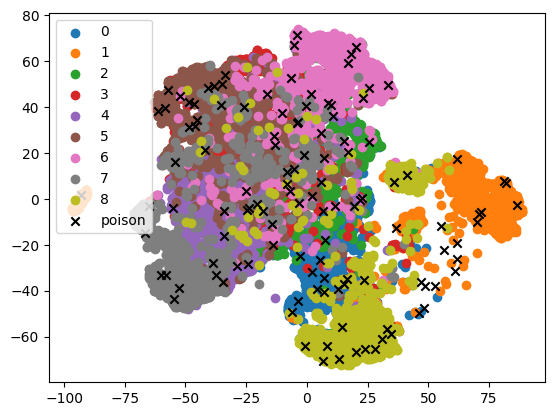

Epoch [101/300]	
	Step [0/391]	 Loss: 3.60368
	Step [50/391]	 Loss: 3.61037
	Step [100/391]	 Loss: 3.60368
	Step [150/391]	 Loss: 3.60242
	Step [200/391]	 Loss: 3.60352
	Step [250/391]	 Loss: 3.61096
	Step [300/391]	 Loss: 3.60093
	Step [350/391]	 Loss: 3.61816

	Training Loss: 3.6043403264506697
	Time Taken: 3.7894660274187726 minutes
Epoch [102/300]	
	Step [0/391]	 Loss: 3.60013
	Step [50/391]	 Loss: 3.59961
	Step [100/391]	 Loss: 3.60261
	Step [150/391]	 Loss: 3.60418
	Step [200/391]	 Loss: 3.60632
	Step [250/391]	 Loss: 3.60237
	Step [300/391]	 Loss: 3.60914
	Step [350/391]	 Loss: 3.60563

	Training Loss: 3.604332626933027
	Time Taken: 3.7932833472887677 minutes
Epoch [103/300]	
	Step [0/391]	 Loss: 3.6059
	Step [50/391]	 Loss: 3.59912
	Step [100/391]	 Loss: 3.60176
	Step [150/391]	 Loss: 3.60473
	Step [200/391]	 Loss: 3.59851
	Step [250/391]	 Loss: 3.61144
	Step [300/391]	 Loss: 3.6112
	Step [350/391]	 Loss: 3.60397

	Training Loss: 3.603797111974653
	Time Taken: 3.794483331839243

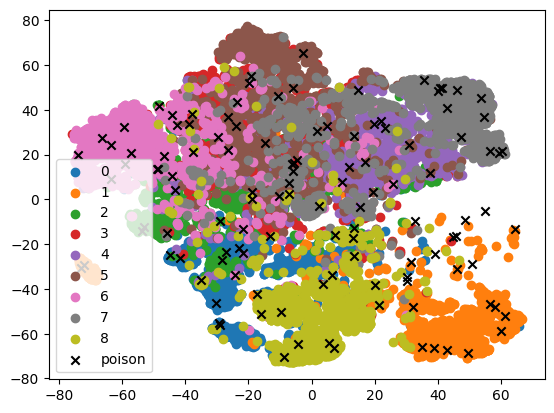

Epoch [111/300]	
	Step [0/391]	 Loss: 3.60716
	Step [50/391]	 Loss: 3.60105
	Step [100/391]	 Loss: 3.61415
	Step [150/391]	 Loss: 3.6008
	Step [200/391]	 Loss: 3.60119
	Step [250/391]	 Loss: 3.60429
	Step [300/391]	 Loss: 3.60701
	Step [350/391]	 Loss: 3.60721

	Training Loss: 3.60232165341487
	Time Taken: 3.795533029238383 minutes
Epoch [112/300]	
	Step [0/391]	 Loss: 3.59937
	Step [50/391]	 Loss: 3.59619
	Step [100/391]	 Loss: 3.60049
	Step [150/391]	 Loss: 3.60026
	Step [200/391]	 Loss: 3.59662
	Step [250/391]	 Loss: 3.59914
	Step [300/391]	 Loss: 3.60164
	Step [350/391]	 Loss: 3.59681

	Training Loss: 3.6025464925009882
	Time Taken: 3.7970500230789184 minutes
Epoch [113/300]	
	Step [0/391]	 Loss: 3.60826
	Step [50/391]	 Loss: 3.59795
	Step [100/391]	 Loss: 3.60142
	Step [150/391]	 Loss: 3.607
	Step [200/391]	 Loss: 3.61659
	Step [250/391]	 Loss: 3.60175
	Step [300/391]	 Loss: 3.60764
	Step [350/391]	 Loss: 3.60583

	Training Loss: 3.602133632011121
	Time Taken: 3.7959166447321575 m

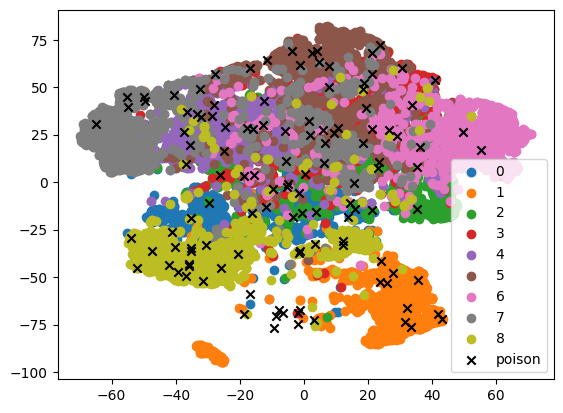

Epoch [121/300]	
	Step [0/391]	 Loss: 3.59918
	Step [50/391]	 Loss: 3.60821
	Step [100/391]	 Loss: 3.60182
	Step [150/391]	 Loss: 3.60419
	Step [200/391]	 Loss: 3.60752
	Step [250/391]	 Loss: 3.59857
	Step [300/391]	 Loss: 3.60133
	Step [350/391]	 Loss: 3.60284

	Training Loss: 3.600495032947082
	Time Taken: 3.7213938077290853 minutes
Epoch [122/300]	
	Step [0/391]	 Loss: 3.60081
	Step [50/391]	 Loss: 3.6011
	Step [100/391]	 Loss: 3.60594
	Step [150/391]	 Loss: 3.59706
	Step [200/391]	 Loss: 3.5994
	Step [250/391]	 Loss: 3.59805
	Step [300/391]	 Loss: 3.60588
	Step [350/391]	 Loss: 3.60292

	Training Loss: 3.600682281167306
	Time Taken: 3.7958000103632608 minutes
Epoch [123/300]	
	Step [0/391]	 Loss: 3.60218
	Step [50/391]	 Loss: 3.59895
	Step [100/391]	 Loss: 3.6027
	Step [150/391]	 Loss: 3.60744
	Step [200/391]	 Loss: 3.61365
	Step [250/391]	 Loss: 3.60072
	Step [300/391]	 Loss: 3.60264
	Step [350/391]	 Loss: 3.60186

	Training Loss: 3.6004905310433233
	Time Taken: 3.7969447414080304

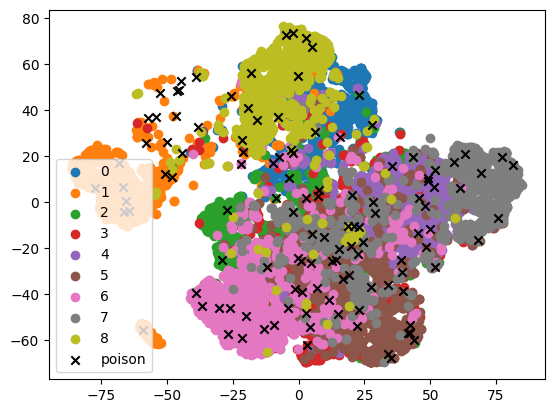

Epoch [131/300]	
	Step [0/391]	 Loss: 3.60543
	Step [50/391]	 Loss: 3.60221
	Step [100/391]	 Loss: 3.60189
	Step [150/391]	 Loss: 3.60054
	Step [200/391]	 Loss: 3.60115
	Step [250/391]	 Loss: 3.60126
	Step [300/391]	 Loss: 3.60366
	Step [350/391]	 Loss: 3.60207

	Training Loss: 3.599294696012726
	Time Taken: 3.8015890240669252 minutes
Epoch [132/300]	
	Step [0/391]	 Loss: 3.59334
	Step [50/391]	 Loss: 3.59979
	Step [100/391]	 Loss: 3.59958
	Step [150/391]	 Loss: 3.59692
	Step [200/391]	 Loss: 3.59958
	Step [250/391]	 Loss: 3.59635
	Step [300/391]	 Loss: 3.60273
	Step [350/391]	 Loss: 3.59862

	Training Loss: 3.599125274306978
	Time Taken: 3.8007348577181497 minutes
Epoch [133/300]	
	Step [0/391]	 Loss: 3.60319
	Step [50/391]	 Loss: 3.59833
	Step [100/391]	 Loss: 3.60175
	Step [150/391]	 Loss: 3.60156
	Step [200/391]	 Loss: 3.59589
	Step [250/391]	 Loss: 3.59828
	Step [300/391]	 Loss: 3.59871
	Step [350/391]	 Loss: 3.60133

	Training Loss: 3.5988527783347517
	Time Taken: 3.8005497415860

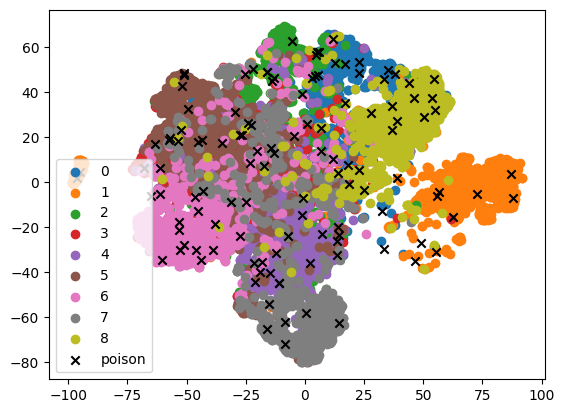

Epoch [141/300]	
	Step [0/391]	 Loss: 3.59951
	Step [50/391]	 Loss: 3.59974
	Step [100/391]	 Loss: 3.59834
	Step [150/391]	 Loss: 3.60385
	Step [200/391]	 Loss: 3.59992
	Step [250/391]	 Loss: 3.60184
	Step [300/391]	 Loss: 3.6
	Step [350/391]	 Loss: 3.59985

	Training Loss: 3.5980270555257188
	Time Taken: 3.804398969809214 minutes
Epoch [142/300]	
	Step [0/391]	 Loss: 3.60016
	Step [50/391]	 Loss: 3.59657
	Step [100/391]	 Loss: 3.60238
	Step [150/391]	 Loss: 3.59668
	Step [200/391]	 Loss: 3.59209
	Step [250/391]	 Loss: 3.60022
	Step [300/391]	 Loss: 3.60103
	Step [350/391]	 Loss: 3.59982

	Training Loss: 3.5978442653060876
	Time Taken: 3.802652382850647 minutes
Epoch [143/300]	
	Step [0/391]	 Loss: 3.59877
	Step [50/391]	 Loss: 3.60102
	Step [100/391]	 Loss: 3.59799
	Step [150/391]	 Loss: 3.59824
	Step [200/391]	 Loss: 3.59586
	Step [250/391]	 Loss: 3.5928
	Step [300/391]	 Loss: 3.59398
	Step [350/391]	 Loss: 3.59634

	Training Loss: 3.597788392430376
	Time Taken: 3.8084188222885134 mi

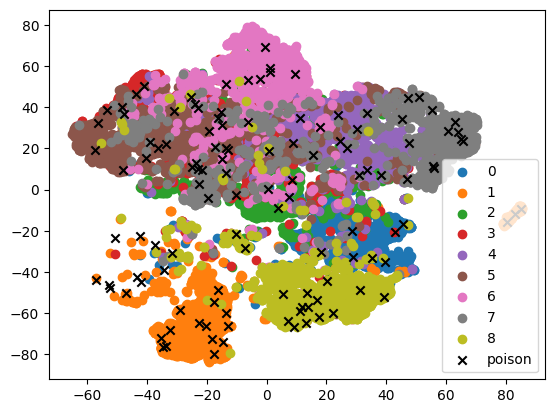

Epoch [151/300]	
	Step [0/391]	 Loss: 3.59965
	Step [50/391]	 Loss: 3.59712
	Step [100/391]	 Loss: 3.60314
	Step [150/391]	 Loss: 3.59528
	Step [200/391]	 Loss: 3.59841
	Step [250/391]	 Loss: 3.59619
	Step [300/391]	 Loss: 3.59954
	Step [350/391]	 Loss: 3.59957

	Training Loss: 3.596661494516046
	Time Taken: 3.8154882113138835 minutes
Epoch [152/300]	
	Step [0/391]	 Loss: 3.59758
	Step [50/391]	 Loss: 3.59226
	Step [100/391]	 Loss: 3.5943
	Step [150/391]	 Loss: 3.5967
	Step [200/391]	 Loss: 3.59514
	Step [250/391]	 Loss: 3.60619
	Step [300/391]	 Loss: 3.60733
	Step [350/391]	 Loss: 3.59616

	Training Loss: 3.5965235227209225
	Time Taken: 3.799574418862661 minutes
Epoch [153/300]	
	Step [0/391]	 Loss: 3.59862
	Step [50/391]	 Loss: 3.59624
	Step [100/391]	 Loss: 3.59886
	Step [150/391]	 Loss: 3.59412
	Step [200/391]	 Loss: 3.59383
	Step [250/391]	 Loss: 3.59428
	Step [300/391]	 Loss: 3.60148
	Step [350/391]	 Loss: 3.59634

	Training Loss: 3.596361429794975
	Time Taken: 3.8140220681826276

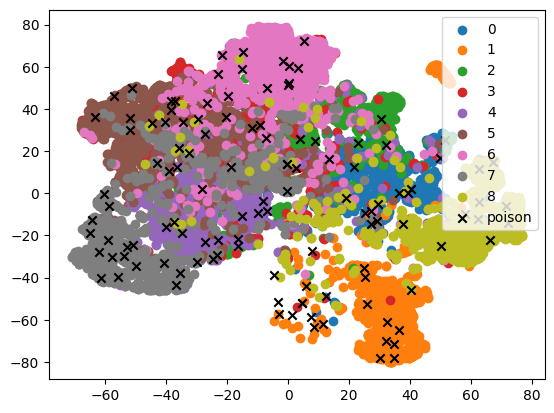

Epoch [161/300]	
	Step [0/391]	 Loss: 3.59617
	Step [50/391]	 Loss: 3.59328
	Step [100/391]	 Loss: 3.5942
	Step [150/391]	 Loss: 3.59525
	Step [200/391]	 Loss: 3.59506
	Step [250/391]	 Loss: 3.60219
	Step [300/391]	 Loss: 3.59412
	Step [350/391]	 Loss: 3.60166

	Training Loss: 3.5952481693014158
	Time Taken: 3.8034238696098326 minutes
Epoch [162/300]	
	Step [0/391]	 Loss: 3.59675
	Step [50/391]	 Loss: 3.59638
	Step [100/391]	 Loss: 3.59916
	Step [150/391]	 Loss: 3.60054
	Step [200/391]	 Loss: 3.5981
	Step [250/391]	 Loss: 3.59286
	Step [300/391]	 Loss: 3.60016
	Step [350/391]	 Loss: 3.59581

	Training Loss: 3.5954246142941058
	Time Taken: 3.802642583847046 minutes
Epoch [163/300]	
	Step [0/391]	 Loss: 3.59557
	Step [50/391]	 Loss: 3.59305
	Step [100/391]	 Loss: 3.59408
	Step [150/391]	 Loss: 3.59804
	Step [200/391]	 Loss: 3.59379
	Step [250/391]	 Loss: 3.59466
	Step [300/391]	 Loss: 3.59678
	Step [350/391]	 Loss: 3.5993

	Training Loss: 3.5952540395204977
	Time Taken: 3.792518496513366

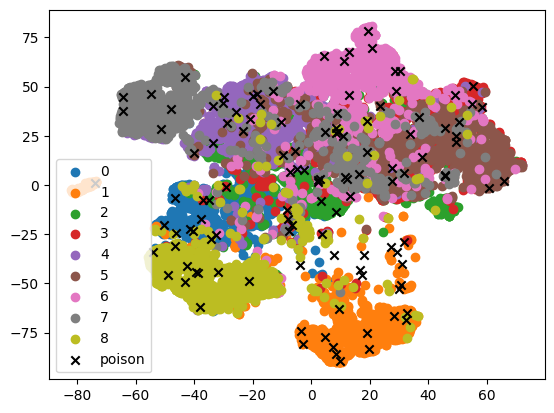

Epoch [171/300]	
	Step [0/391]	 Loss: 3.59746
	Step [50/391]	 Loss: 3.59812
	Step [100/391]	 Loss: 3.60072
	Step [150/391]	 Loss: 3.59172
	Step [200/391]	 Loss: 3.59447
	Step [250/391]	 Loss: 3.59258
	Step [300/391]	 Loss: 3.59436
	Step [350/391]	 Loss: 3.59431

	Training Loss: 3.5943612253574457
	Time Taken: 3.673813203970591 minutes
Epoch [172/300]	
	Step [0/391]	 Loss: 3.59209
	Step [50/391]	 Loss: 3.59424
	Step [100/391]	 Loss: 3.59499
	Step [150/391]	 Loss: 3.59025
	Step [200/391]	 Loss: 3.59589
	Step [250/391]	 Loss: 3.59347
	Step [300/391]	 Loss: 3.59858
	Step [350/391]	 Loss: 3.60183

	Training Loss: 3.5940598734199543
	Time Taken: 3.7661571582158406 minutes
Epoch [173/300]	
	Step [0/391]	 Loss: 3.60142
	Step [50/391]	 Loss: 3.59119
	Step [100/391]	 Loss: 3.5924


KeyboardInterrupt: 

In [28]:
losses = []

for epoch in range(start_epoch, epochs+1):
    print(f"Epoch [{epoch}/{epochs}]\t")
    stime = time.time()

    model.train()
    loss = train(dataloader, model, criterion, optimizer)
    losses.append(loss)

    if epoch <= 10:
        warmupscheduler.step()
    if epoch > 10:
        mainscheduler.step()
    
    print()
    print(f"\tTraining Loss: {loss}")
    time_taken = (time.time()-stime)/60
    print(f"\tTime Taken: {time_taken} minutes")

    if (epoch) % 10 == 0:
        save_model(model, optimizer, mainscheduler, epoch, f"NEW-SimCLR-{epoch}.pt")
        plot_features(model, dataloader_no_contrastive, 100)

## end training
save_model(model, optimizer, mainscheduler, epochs, f"NEW-SimCLR.pt-{epoch}")